## Import necessary libraries

In [41]:
import os

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, \
                          Flatten, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.resnet50 import ResNet50
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

## Define hyperparameters

In [42]:
BATCH_SIZE = 32
EPOCHS = 30
IMG_HEIGHT = 48
IMG_WIDTH = 48
NUM_OUTPUTS = 5
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.3
L2_WEIGHT_DECAY = 1e-6

os.chdir("../SadOrHappy_ML_Madcamp_Week3")

The dataset has following directory structure:

<pre>
<b>dataset</b>
|__ <b>train</b>
    |______ <b>angry</b>: [0.jpg, 1.jpg, 10.jpg, ...]
    |______ <b>happy</b>: [100.jpg, 10000.jpg, 10001.jpg, ...]
    |______ <b>neutral</b>: [1000.jpg, 10003.jpg, 10014.jpg, ...]
    |______ <b>sad</b>: [10006.jpg, 10008.jpg, 1001.jpg, ...]
    |______ <b>surprise</b>: [10007.jpg, 10009.jpg, 10011.jpg, ...]
|__ <b>validation</b>
    |______ <b>angry</b>: [10052.jpg, 10065.jpg, 10079.jpg, ....]
    |______ <b>happy</b>: [10019.jpg, 10023.jpg, 10074.jpg, ...]
    |______ <b>neutral</b>: [10033.jpg, 10048.jpg, 10068.jpg, ...]
    |______ <b>sad</b>: [10004.jpg, 1003.jpg, 10031.jpg, ...]
    |______ <b>surprise</b>: [10056.jpg, 10097.jpg, 10162.jpg, ...]
</pre>

In [43]:
train_dir = os.path.join("./dataset", "train")
validation_dir = os.path.join("./dataset", "validation")

train_angry_dir = os.path.join(train_dir, "angry")
train_happy_dir = os.path.join(train_dir, "happy")
train_neutral_dir = os.path.join(train_dir, "neutral")
train_sad_dir = os.path.join(train_dir, "sad")
train_surprise_dir = os.path.join(train_dir, "surprise")

validation_angry_dir = os.path.join(validation_dir, "angry")
validation_happy_dir = os.path.join(validation_dir, "happy")
validation_neutral_dir = os.path.join(validation_dir, "neutral")
validation_sad_dir = os.path.join(validation_dir, "sad")
validation_surprise_dir = os.path.join(validation_dir, "surprise")

num_angry_tr = len(os.listdir(train_angry_dir))
num_happy_tr = len(os.listdir(train_happy_dir))
num_neutral_tr = len(os.listdir(train_neutral_dir))
num_sad_tr = len(os.listdir(train_sad_dir))
num_surprise_tr = len(os.listdir(train_surprise_dir))

num_angry_val = len(os.listdir(validation_angry_dir))
num_happy_val = len(os.listdir(validation_happy_dir))
num_neutral_val = len(os.listdir(validation_neutral_dir))
num_sad_val = len(os.listdir(validation_sad_dir))
num_surprise_val = len(os.listdir(validation_surprise_dir))

total_train = num_angry_tr + num_happy_tr + num_neutral_tr + num_sad_tr + num_surprise_tr
total_val = num_angry_val + num_happy_val + num_neutral_val + num_sad_val + num_surprise_val

# debug
print('total # of training set :', total_train)
print('total # of train_angry :', num_angry_tr)
print('total # of train_happy :', num_happy_tr)
print('total # of train_neutral :', num_neutral_tr)
print('total # of train_sad :', num_sad_tr)
print('total # of train_surprise :', num_surprise_tr, "\n")

print('total # of validation set :', total_val)
print('total # of validation_angry :', num_angry_val)
print('total # of validation_happy :', num_happy_val)
print('total # of validation_neutral :', num_neutral_val)
print('total # of validation_sad :', num_sad_val)
print('total # of validation_surprise :', num_surprise_val)

total # of training set : 107923
total # of train_angry : 16620
total # of train_happy : 28604
total # of train_neutral : 34234
total # of train_sad : 17145
total # of train_surprise : 11320 

total # of validation set : 30443
total # of validation_angry : 2893
total # of validation_happy : 12758
total # of validation_neutral : 12860
total # of validation_sad : 1138
total # of validation_surprise : 794


## Preprocess the dataset

In [44]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [45]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = train_dir,
    color_mode = 'grayscale',
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = validation_dir,
    color_mode = 'grayscale',
    shuffle = False,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
  )

Found 107915 images belonging to 5 classes.
Found 30443 images belonging to 5 classes.


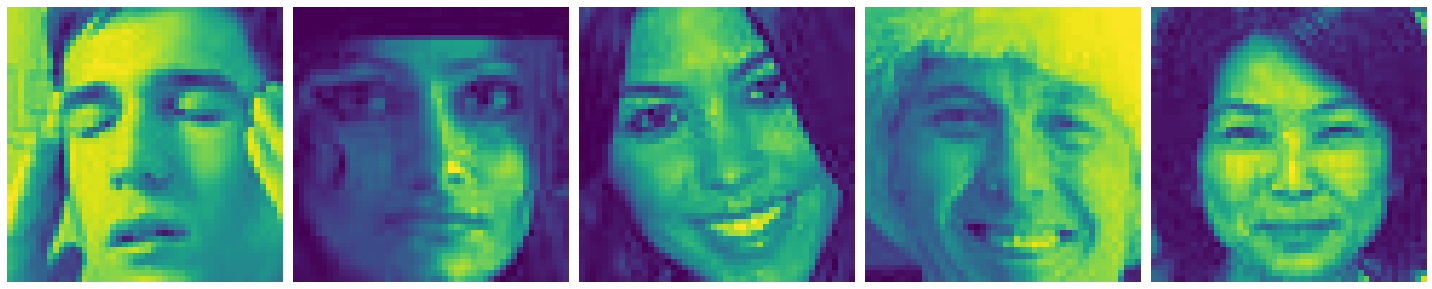

In [46]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Define model

In [47]:
def simple_cnn():
  model = Sequential()
  input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
  model.add(Conv2D(128, (5, 5), input_shape=input_shape, activation='relu', padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))    
    
  model.add(Conv2D(128, (3, 3),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(NUM_OUTPUTS, activation="softmax"))
  model.add(Activation('softmax'))
  return model

def resnet_fine_tuning():
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(NUM_OUTPUTS, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=x)
  return model

model = simple_cnn()
# model = resnet_fine_tuning()

optimizer = Adam(lr = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = optimizer)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 48, 48, 128)       3328      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 48, 48, 128)       409728    
_________________________________________________________________
batch_normalization_24 (Batc (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 24, 128)       409728    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 24, 128)      

## Train model

In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount = False)

# def get_drive_path():
#   path = F"/content/gdrive/MyDrive/Colab Notebooks/weights/"
#   path += "weights_{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.h5"
#   return path

def get_local_path():
  path = os.path.join("weights/", "weights_{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.h5")
  return path

# path = get_drive_path()
path = get_local_path()
save_model_callback = ModelCheckpoint(filepath = path)

history = model.fit(
    train_data_gen,
    steps_per_epoch = total_train // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    validation_steps = total_val // BATCH_SIZE,
    callbacks = [save_model_callback]
)

Epoch 1/100
3372/3372 [==============================] - 70s 21ms/step - loss: 1.4545 - accuracy: 0.4339 - val_loss: 1.3817 - val_accuracy: 0.5140
Epoch 2/100
3372/3372 [==============================] - 69s 21ms/step - loss: 1.3316 - accuracy: 0.5654 - val_loss: 1.3489 - val_accuracy: 0.5472
Epoch 3/100
 360/3372 [==>...........................] - ETA: 50s - loss: 1.3041 - accuracy: 0.5962

## Plot training result

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()